In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier

In [47]:
col = ["user_id", "priority", "application_name", "timeposted", "timeremoved", "sound", "default_sound", "led", "default_led", "default_vibration", "ringermode", "idle", "interactive", "screen_state", "lock_scr_notifs"]

df = pd.read_csv('data.txt', header=None, sep=" ")
df.drop(1, 1, inplace=True)
df.drop(2, 1, inplace=True)
df.drop(11, 1, inplace=True)
df.drop(18, 1, inplace=True)
df.replace(',','', regex=True, inplace=True)
df.replace('\'','', regex=True, inplace=True)
df = pd.DataFrame(data = np.array(df), columns=col)

indexNames = df[ df['timeremoved'] == '0' ].index
df.drop(indexNames , inplace=True)

response_time = df["timeremoved"].values.astype(int) - df["timeposted"].values.astype(int)
df['response_time'] = response_time
df.drop("timeposted", 1, inplace=True)
df.drop("timeremoved", 1, inplace=True)

indexNames = df[ df['response_time'] <= 0 ].index
df.drop(indexNames , inplace=True)

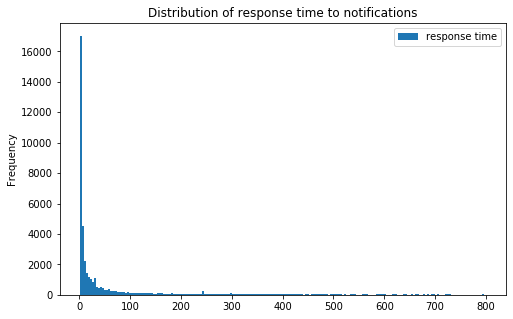

In [48]:
t = df[df['response_time'] <= 800]
rt = pd.DataFrame({'response time':t['response_time']})
ax = rt.plot.hist(title="Distribution of response time to notifications", figsize=(8,5), bins=200)

In [49]:
df = shuffle(df, random_state=25)

m = np.mean(df["response_time"].values)
print(f'Mean of response_time: {m} sec\n')


y = df.loc[:, 'response_time'].values
binary_y = []

for i in y:
    if i<m:
        binary_y.append(1) #high
    else:
        binary_y.append(0) #low

binary_y = np.array(binary_y)
df['attentiveness'] = binary_y
df.drop("response_time", 1, inplace=True)


X = df.loc[:, :'lock_scr_notifs'].values
X_no_id = df.loc[:,"priority":'lock_scr_notifs'].values

enc = OrdinalEncoder()
X = enc.fit_transform(X)
X_no_id = enc.fit_transform(X_no_id)

df

Mean of response_time: 575.1461862121049 sec



,user_id,priority,application_name,sound,default_sound,led,default_led,default_vibration,ringermode,idle,interactive,screen_state,lock_scr_notifs,attentiveness
69242,12,2,com.skype.raider,0,0,0,0,0,0,0,0,1,1,0
88362,13,0,android,0,0,0,0,0,2,0,1,2,1,1
28106,1,2,com.skype.raider,0,0,1,0,0,2,0,1,2,1,1
69316,12,0,com.facebook.orca,0,0,1,0,0,2,0,1,2,1,1
70830,12,0,com.facebook.orca,1,0,1,0,0,2,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149494,5,0,com.twitter.android,1,0,1,0,1,2,0,0,1,1,1
129810,2,0,com.lge.keepscreenon,0,0,0,0,0,2,0,1,2,1,1
55024,11,2,com.android.incallui,0,0,0,0,0,2,0,1,2,1,1
125599,2,0,android,0,0,0,0,0,2,0,1,2,1,1


Text(0.5, 1, 'feature correlation')

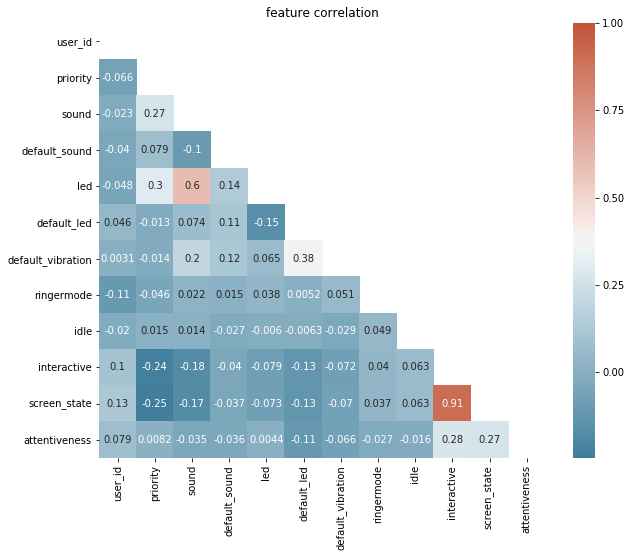

In [50]:
df.to_csv("corr.csv", index = False)
dff = pd.read_csv('corr.csv', sep=",")
dff.drop("lock_scr_notifs", 1, inplace=True)

corr = dff.corr()

f, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title("feature correlation")

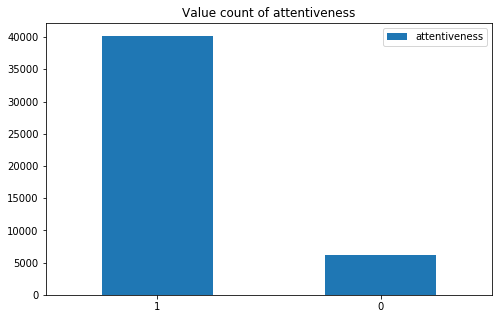

In [51]:
rt = pd.DataFrame({'attentiveness':df['attentiveness'].value_counts()})
ax = rt.plot.bar(rot=0, title="Value count of attentiveness", figsize=(8,5))

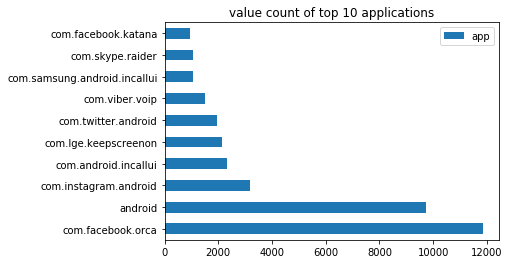

In [52]:
features = []
for e in df['application_name'].values:
    features.append(e)

f = pd.DataFrame(data = np.array(features))
label_cnt = pd.DataFrame({'app':f[0].value_counts().nlargest(10)})
ax = label_cnt.plot.barh(title='value count of top 10 applications')

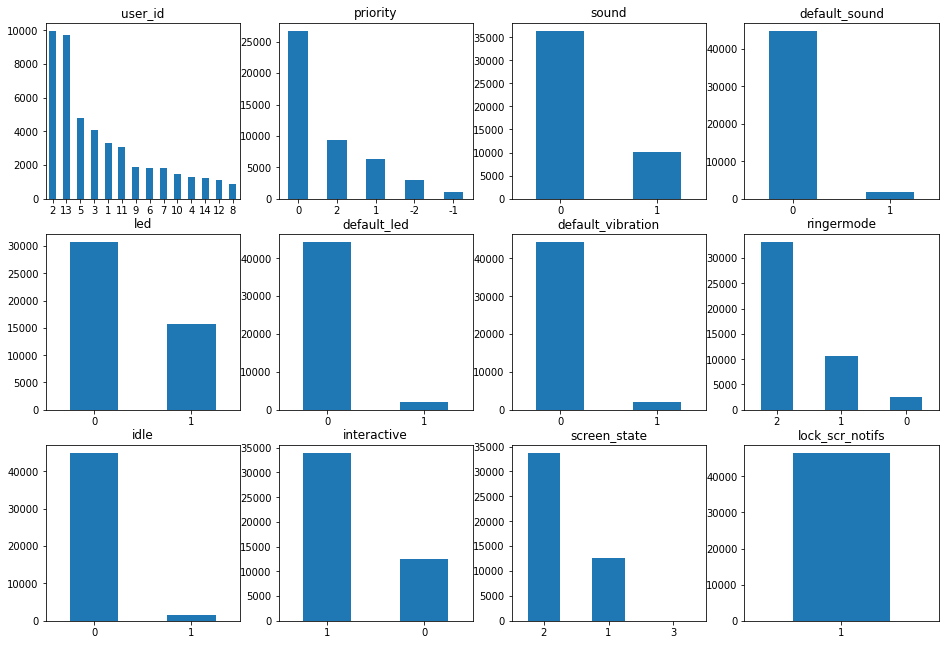

In [53]:
coll = ["user_id","priority", "sound", "default_sound", "led", "default_led", "default_vibration", "ringermode", "idle", "interactive", "screen_state", "lock_scr_notifs"]

fig, axes = plt.subplots(3, 4 ,figsize=(16,11))

for i, attribute in enumerate(coll):
    tmp = pd.DataFrame({'feature':df[attribute].value_counts()})
    ax = tmp.plot.bar(rot=0, title=attribute, ax=axes[i//4,i%4])
    ax.get_legend().remove()

In [54]:
result = []

def Validation(model, X):
    cal = []
    y_test_list = []
    y_pred_list = []

    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = binary_y[train_index], binary_y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_list = [*y_test_list, *y_test]
        y_pred_list = [*y_pred_list, *y_pred]
        
        acc = classification_report(y_test, y_pred, output_dict=True)['accuracy']
        precision_0 = classification_report(y_test, y_pred, output_dict=True)['0']['precision']
        recall_0 = classification_report(y_test, y_pred, output_dict=True)['0']['recall']
        precision_1 = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
        recall_1 = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
        cm = confusion_matrix(y_test, y_pred)
        
        cal.append([acc, precision_0, recall_0, precision_1, recall_1, cm])

    acc_avg = (cal[0][0] + cal[1][0] + cal[2][0]) / 3 
    precision_0_avg = (cal[0][1] + cal[1][1] + cal[2][1]) / 3
    recall_0_avg = (cal[0][2] + cal[1][2] + cal[2][2]) / 3
    precision_1_avg = (cal[0][3] + cal[1][3] + cal[2][3]) / 3
    recall_1_avg = (cal[0][4] + cal[1][4] + cal[2][4]) / 3
    cm_avg = np.mean(np.array([cal[0][5], cal[1][5], cal[2][5]]), axis=0, dtype=np.int)
    result.append([acc_avg, precision_0_avg, recall_0_avg, precision_1_avg, recall_1_avg, cm_avg])
    

In [55]:
print("Data with user_id")

Validation(CategoricalNB(alpha=1),X)
Validation(RandomForestClassifier(n_estimators=10), X)
Validation(SVC(kernel='rbf', gamma=0.7), X)
Validation(MLPClassifier(hidden_layer_sizes=(200,), max_iter=500), X)

c = ["Accuracy", "Precision_0", "Recall_0", "Precision_1", "Recall_1", "Confusion matrix"]
idx = ["Naïve Bayes", "Random Forest", "SVM", "MLP classifier"]

table = pd.DataFrame(data = np.array(result), columns=c, index=idx)
table

Data with user_id


,Accuracy,Precision_0,Recall_0,Precision_1,Recall_1,Confusion matrix
Naïve Bayes,0.852715,0.445881,0.517044,0.925472,0.903273,"[[313, 293], [389, 3638]]"
Random Forest,0.900036,0.715017,0.392315,0.91431,0.976503,"[[238, 368], [94, 3933]]"
SVM,0.900467,0.74157,0.367529,0.911474,0.980715,"[[223, 383], [77, 3950]]"
MLP classifier,0.888889,0.672785,0.292594,0.901862,0.978659,"[[177, 429], [86, 3942]]"


In [56]:
result.clear()

print("Data without user_id")

Validation(CategoricalNB(alpha=1),X_no_id)
Validation(RandomForestClassifier(n_estimators=10), X_no_id)
Validation(SVC(kernel='rbf', gamma=0.7), X_no_id)
Validation(MLPClassifier(hidden_layer_sizes=(200,), max_iter=1000), X_no_id)

table_no_id = pd.DataFrame(data = np.array(result), columns=c, index=idx)
table_no_id

Data without user_id


,Accuracy,Precision_0,Recall_0,Precision_1,Recall_1,Confusion matrix
Naïve Bayes,0.852643,0.444447,0.503931,0.923745,0.90518,"[[305, 301], [382, 3646]]"
Random Forest,0.897087,0.711399,0.360111,0.910277,0.977998,"[[218, 388], [88, 3939]]"
SVM,0.897591,0.737711,0.337823,0.9078,0.98187,"[[205, 401], [73, 3955]]"
MLP classifier,0.8863,0.723432,0.224735,0.894101,0.98605,"[[136, 470], [56, 3972]]"
